# Music Genre Recognition on GTZAN

This file should be used in Google Colab otherwise you might face issues during running the code on your local machine. Also, **it is important to note that you need to run the code with GPU and High-RAM which prevents you to face errors.** This is completely tested and should work for you as well. Even if it does not work for you we can setup a session to help you make it work.

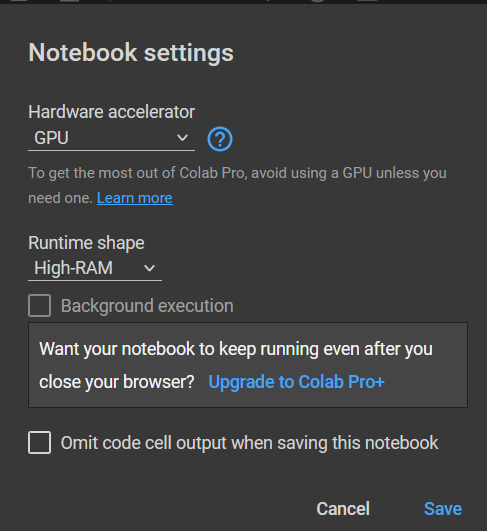

# Clone the Repository

We have used Github to store our code resource. The link to our repository is available on [Genrecog Github Repository](https://github.com/ConcoLab/genrecog). However, this code pulls the latest version of Genrecog for you. Also, you need to install SpeechBrain since it is not available as a default library on Colab.

In [1]:
%%capture
%cd /content
!git clone https://github.com/ConcoLab/genrecog.git
%cd /content/genrecog

%pip install speechbrain

#Download Dataset

**Do not forget to uncomment one of the methods to make it work.**

In the next step you need to download the `train.npz` and `test.npz` dataset to the `dataset/npz_files/`.

Please note that we tried `gdown` to download the datasets from Drive, however, it is not stable and we do not recommend it. You can uncomment the first cell to see if `gdown` works fine. If it works, then keep the second cell as commented. Otherwise you can use the second cell.

The other cell downloads the dataset from our storage on Concordia Storage.

 This can be done manually by using following links:

**train.npz**

[Concordia Storage](https://users.encs.concordia.ca/~a_hraf/train.npz) or [Google Drive](https://drive.google.com/file/d/1gPI8Jd94jCniZLHC2-KLVHPw0HlfNvFx/view?usp=sharing)



**test.npz**

[Concordia Storage](https://users.encs.concordia.ca/~a_hraf/test.npz) or [Google Drive](https://drive.google.com/file/d/1ZkJwOQPGR_okWNAPbJ8_6YtDOCog5fg3/view?usp=sharing)





In [2]:
# You should see two files on dataset/npz_files
# if they are downloaded well.

# !pip install --upgrade --no-cache-dir gdown
# %cd /content/genrecog/dataset/npz_files
# !gdown --id 1ZkJwOQPGR_okWNAPbJ8_6YtDOCog5fg3
# !gdown --id 1gPI8Jd94jCniZLHC2-KLVHPw0HlfNvFx
# %cd /content/genrecog
# %ls /content/genrecog/dataset/npz_files

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=8dc8c06920eb5644927bc4adc007e1faba5b0338902b786517a7f195b69f8502
  Stored in directory: /tmp/pip-ephem-wheel-cache-c33bd8x2/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
/content/genrecog/dataset/npz_files
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZkJwOQPGR_okWNAPbJ8_6YtDOCog5fg3
To: /content/genrecog/dataset/npz_files/test.npz
100% 247M/247M [00:03<00:00, 75.

In [3]:
# You can try the second way. Uncomment to make it work.

# !wget -O dataset/npz_files/train.npz -c "https://users.encs.concordia.ca/~a_hraf/train.npz"
# !wget -O dataset/npz_files/test.npz -c "https://users.encs.concordia.ca/~a_hraf/test.npz"

# Loading The Libraries

We used publicly available libraries and our developed libraries which are available on Github.

In [4]:
# Essntial Libraries
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.nnet.CNN import Conv1d, VanillaConv1d, VanillaConv2d
from genrecog.nnet.RNN import VanillaRNN, LSTM, GRU
from genrecog.tools.trainer import CNNFbankTrainer, RNNFbankTrainer, SklearnTrainer, KmeansTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader 
import datetime
from genrecog.preprocess.feature import Feature
from IPython.display import Audio
import matplotlib.pyplot as plt



torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setting the Dataset Path

You can use the following cell to set the path to the datasets. If you weren't able to download the dataset, you can easily put it on your `Google Drive` and mont your drive. Then you can use that path to make the code work. Do not forget to update the following path.

In [5]:
train_preprcessor = Preprocessor('dataset/npz_files/train.npz')
test_preprcessor = Preprocessor('dataset/npz_files/test.npz')


# Processed Data
The following code shows that we actually using a set of musics which are converted to waves and then we use Fast Fourier Transform (FFT) with using a library available in speechbrain library (FBank) to extract the features.

In [6]:
# Load a sample dataset for demonstration purposes
X_test, y_test = test_preprcessor.as_shuffled_numpy()

## Listen a Part of a Music
Each sample in X_test is a music sample that you can listen to and they have a length of 7 seconds.

In [7]:
Audio(X_test[0], rate=22050)

Also you can see the wave resulting from each sample that is gotten from the music.

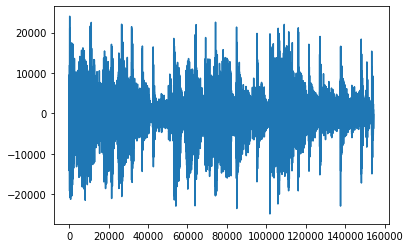

In [8]:
plt.plot(X_test[0])

Now, it is the time to extract the features off the sample. So, you can see that each sample is turned to a two-dimensional array containig FFT samples.

In [9]:
feature_maker = Feature()
print("Shape of the music waves:", X_test.shape)
X_test_features = feature_maker.numpy_fbank_features(X_test)
print("Resulted sample features shape:", X_test_features.shape)


Shape of the music waves: (400, 154350)
Resulted sample features shape: (400, 702, 40)


And finally we can plot the features:

Text(0.5, 0, 'time')

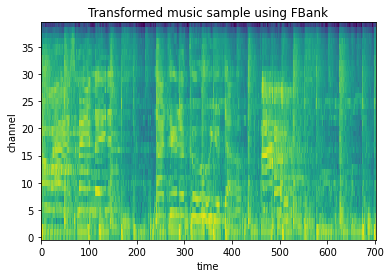

In [10]:
plt.imshow(X_test_features[0].T, 
           cmap='viridis', 
           interpolation='nearest', 
           aspect='auto', origin='left, bottom')
plt.title('Transformed music sample using FBank')
plt.ylabel('channel')
plt.xlabel('time')

# 1. Neural Network Data Preparation

To train neural network models, we need to define the DataLoaders. So, we have prepared three different DataLoaders for training, validation and test. This allowed us to reuse the same method for both RNN and CNN at the further steps. 

**It is important to note that we set the size of batches to 400 and you might need to change it due to RAM constraints.**

In [11]:
batch_size = 400 # If your RAM does not support you can replace it with 100

X, y = train_preprcessor.as_shuffled_torch()
X_test, y_test = test_preprcessor.as_shuffled_torch()

dataset = TensorDataset(X.to(device), y.to(device))
validation_dataset, train_dataset = torch.utils.data.random_split(dataset, (400, 3200))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

Also, we took 100 as the numnber of epochs in all of the trained models before deciding for overfitting. Here you are able to set it to 100 if you'd like to compare our stated results with this notebook. You would be able to see all the epochs' information after each training process.

In [12]:
num_epochs=100 # You can change it to 100 for closer results

# 2. Recurrent Neural Network

We have decided to train different models on RNN to see which of them works better than the others. So, we fixed the following hyperparameters and change the RNN core functions. The layer that are used include VanillaRNN, LSTM, and GRU. Also, for each of them we used two different variations. One was taking the last hidden layer as the output of the forward function and the other was taking the average of all hidden layers as the output function.

In [13]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001

## 2.1. VanillaRNN with Using Last Layer of the Hidden Layers

VanillaRNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 28.28
Training loss 2.0398
Validation accuracy 14.75
Validation loss 2.2667
============================== EPOCH 2 =================================
Training accuracy 36.53
Training loss 1.7968
Validation accuracy 24.75
Validation loss 2.0805
============================== EPOCH 3 =================================
Training accuracy 39.97
Training loss 1.7178
Validation accuracy 29.75
Validation loss 1.8690
============================== EPOCH 4 =================================
Training accuracy 40.66
Training loss 1.6712
Validation accuracy 35.00
Validation loss 

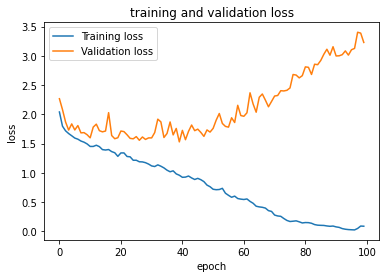

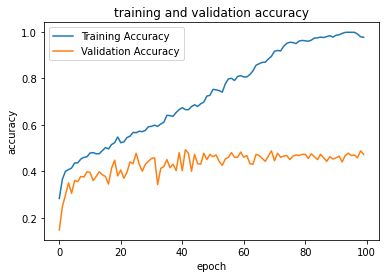

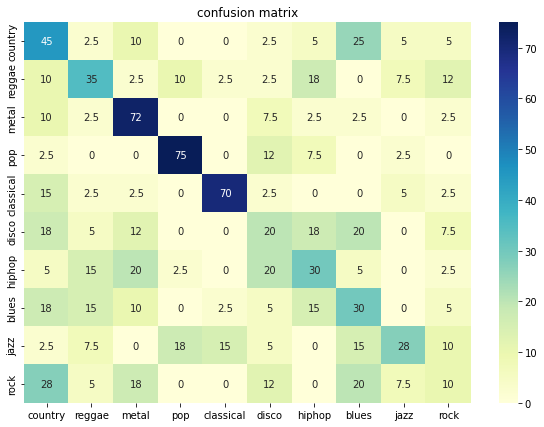

accuracy:  41.49999916553497


In [14]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.2. VanillaRNN with Using Mean Value of All Hidden Layers

VanillaRNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 31.19
Training loss 1.8518
Validation accuracy 22.00
Validation loss 2.2209
============================== EPOCH 2 =================================
Training accuracy 43.53
Training loss 1.5502
Validation accuracy 16.00
Validation loss 2.1400
============================== EPOCH 3 =================================
Training accuracy 48.56
Training loss 1.4516
Validation accuracy 32.00
Validation loss 1.8547
============================== EPOCH 4 =================================
Training accuracy 52.56
Training loss 1.3589
Validation accuracy 31.75
Validation loss 

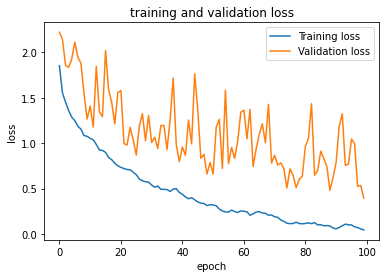

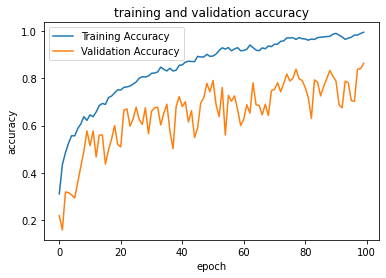

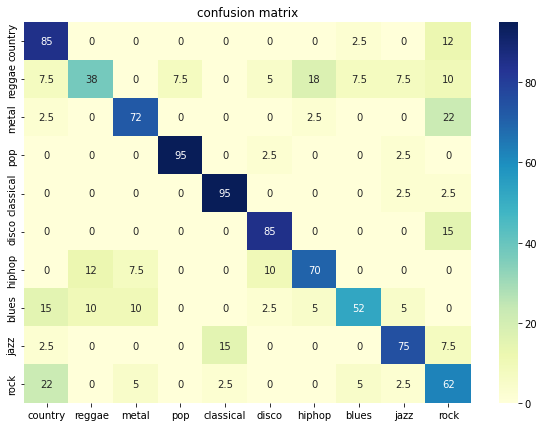

accuracy:  72.99999594688416


In [15]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.3. LSTM with Using Last Layer of Hidden Layers

LSTM(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 29.91
Training loss 1.9583
Validation accuracy 9.75
Validation loss 2.2964
============================== EPOCH 2 =================================
Training accuracy 39.31
Training loss 1.7293
Validation accuracy 10.00
Validation loss 2.2741
============================== EPOCH 3 =================================
Training accuracy 41.72
Training loss 1.6334
Validation accuracy 20.75
Validation loss 2.2425
============================== EPOCH 4 =================================
Training accuracy 43.50
Training loss 1.5698
Validation accuracy 23.50
Validation loss 2.201

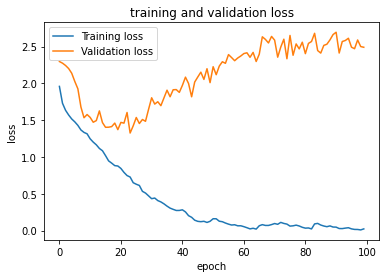

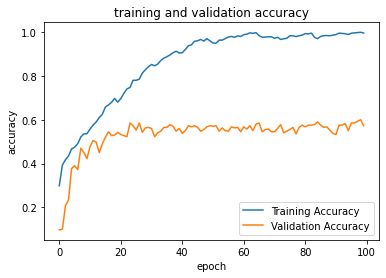

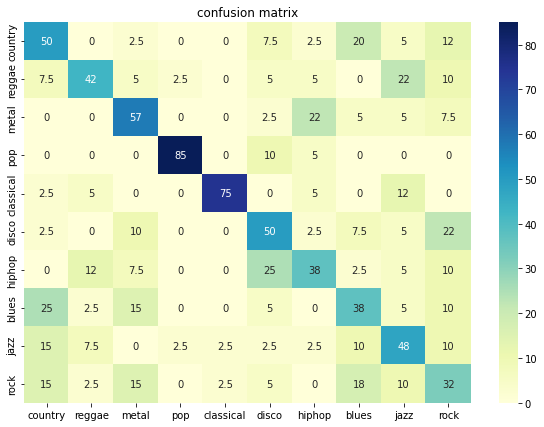

accuracy:  51.499998569488525


In [16]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = LSTM(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.4. LSTM with Using Mean Value of All Hidden Layers

LSTM(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 29.50
Training loss 1.9146
Validation accuracy 9.75
Validation loss 2.3018
============================== EPOCH 2 =================================
Training accuracy 43.75
Training loss 1.5513
Validation accuracy 17.25
Validation loss 2.2650
============================== EPOCH 3 =================================
Training accuracy 48.72
Training loss 1.4254
Validation accuracy 26.75
Validation loss 2.2015
============================== EPOCH 4 =================================
Training accuracy 52.22
Training loss 1.3340
Validation accuracy 37.50
Validation loss 2.119

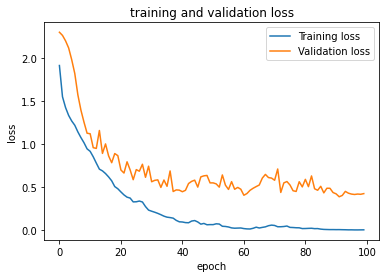

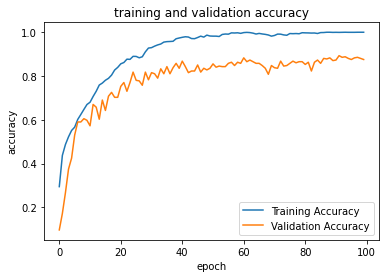

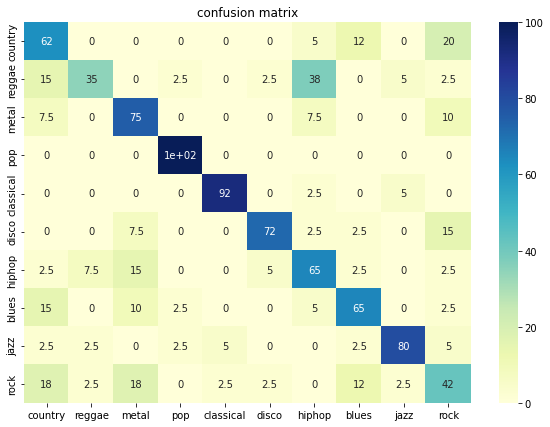

accuracy:  68.99999976158142


In [17]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = LSTM(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.5. GRU with Using Last Layer of the Hidden Layers

GRU(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glu): GRU(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 32.31
Training loss 1.8996
Validation accuracy 15.00
Validation loss 2.2452
============================== EPOCH 2 =================================
Training accuracy 38.81
Training loss 1.7291
Validation accuracy 36.00
Validation loss 2.1016
============================== EPOCH 3 =================================
Training accuracy 42.69
Training loss 1.6533
Validation accuracy 38.00
Validation loss 1.9437
============================== EPOCH 4 =================================
Training accuracy 43.19
Training loss 1.5878
Validation accuracy 40.75
Validation loss 1.7806


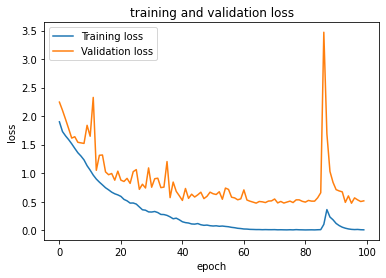

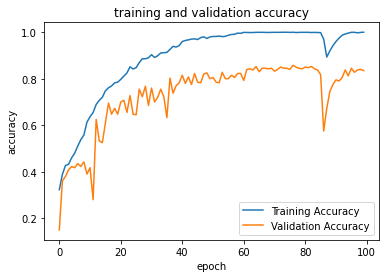

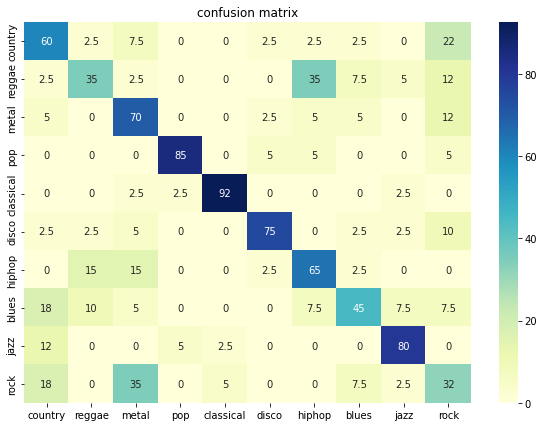

accuracy:  63.999998569488525


In [18]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = GRU(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.6. GRU with Using Mean Value of All Hidden Layers

GRU(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glu): GRU(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 31.19
Training loss 1.9350
Validation accuracy 17.00
Validation loss 2.2587
============================== EPOCH 2 =================================
Training accuracy 43.03
Training loss 1.5653
Validation accuracy 20.75
Validation loss 2.1336
============================== EPOCH 3 =================================
Training accuracy 48.16
Training loss 1.4551
Validation accuracy 42.75
Validation loss 1.9403
============================== EPOCH 4 =================================
Training accuracy 52.00
Training loss 1.3522
Validation accuracy 51.50
Validation loss 1.7785


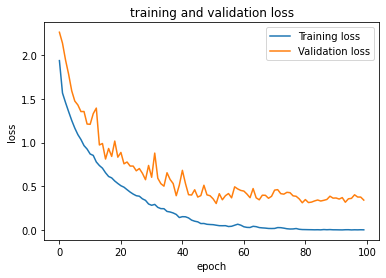

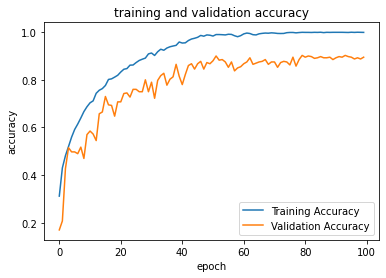

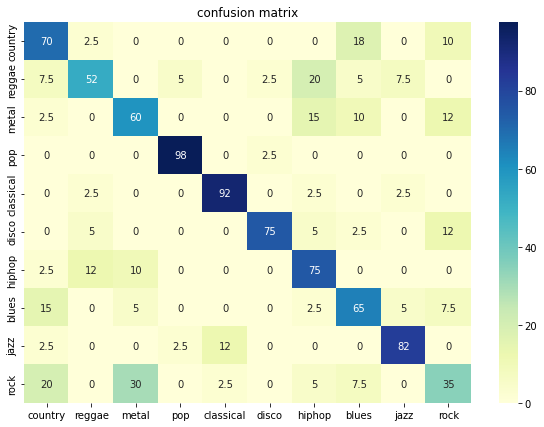

accuracy:  70.49999833106995


In [19]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = GRU(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

# 3. Convolutional Neural Network
After examining the RNN to train a classifier for our project, we have decided to use CNN to compare our result with. We have trained three different models for our CNN including VanillaConv1d, VanillaConv1d, Conv2d, which each of them becomes more complex in terms of architecture. Also, we tried to keep the architecture close to RNN which makes the results compareable. As of this reason, we used learning rate equal to 0.001 for all CNN models.


In [20]:
lr = 0.001

## 3.1. VanillaConv1d 

VanillaConv1d(
  (batch_norm): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_layer): Sequential(
    (0): Conv1d(40, 128, kernel_size=(8,), stride=(1,), padding=(8,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer): Sequential(
    (0): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(8,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (out_linear): Linear(in_features=384, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 39.31
Training loss 1.7233
Validation accuracy 13.00
Validation loss 7.8252
================

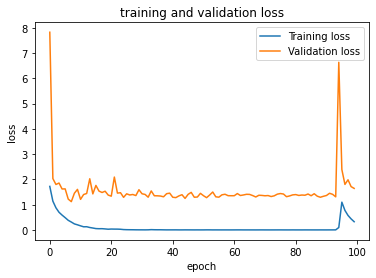

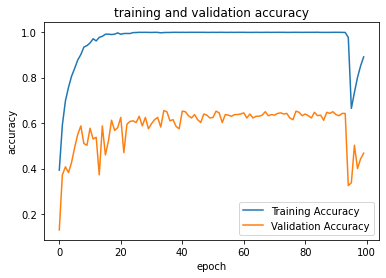

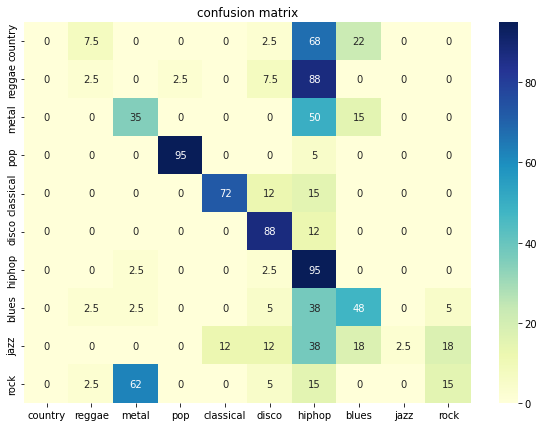

accuracy:  45.249998569488525


In [21]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
model = VanillaConv1d().to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = CNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 3.2. Conv1d

Conv1d(
  (batch_norm): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_layer): Sequential(
    (0): Conv1d(40, 128, kernel_size=(32,), stride=(1,), padding=(16,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer_1): Sequential(
    (0): Conv1d(128, 256, kernel_size=(32,), stride=(1,), padding=(16,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer_2): Sequential(
    (0): Conv1d(256, 512, kernel_size=(32,), stride=(1,), padding=(16,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(

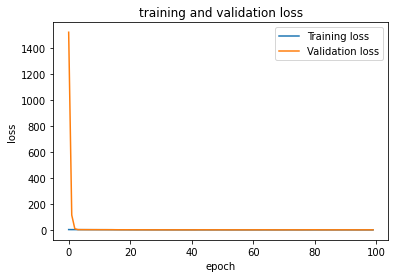

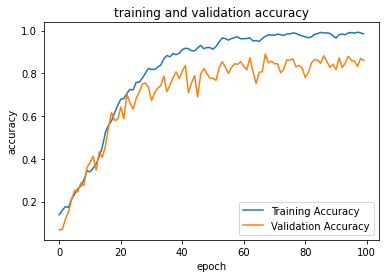

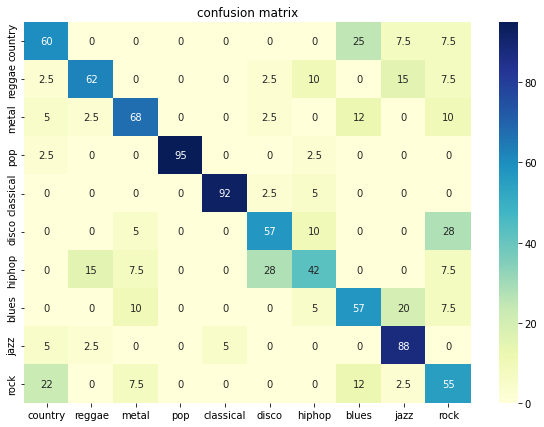

accuracy:  67.75000095367432


In [22]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = Conv1d().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainer = CNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 3.3. VanillaConv2d

VanillaConv2d(
  (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_conv): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 32), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=10624, out_features=10, bias=True)
)
============================== EPOCH 1 =================================
Training accuracy 16.25
Training loss 5.9999
Validation accuracy 13.00
Validation loss 49.6955
============================== EPOCH 2 =================================
Training accuracy 19.81
Training loss 3.7526
Validation accuracy 15.00
Validation loss 6.5536
============================== EPOCH 3 =================================
Training accuracy 21.97
Training loss 2.5678
Validation accuracy 18.00
Validation loss 3.0554
================

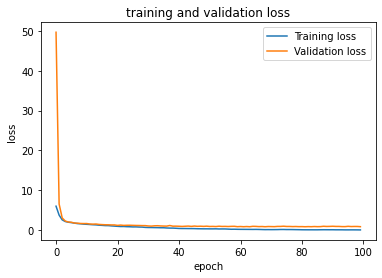

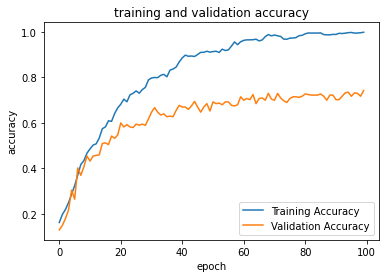

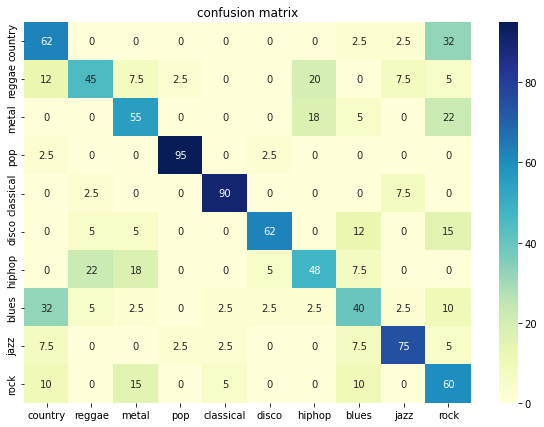

accuracy:  63.24999928474426


In [23]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = VanillaConv2d().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainer = CNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

In [24]:
# Free Memory :)
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss

# 4. Multiple Model Training
In this part, we have written a class which is responsible to train some of the `sklearn` models. So, we can pass a dictionary of various models with different parameters to a the class and it trains them all one by one. This was helpful for hyperparameter search.




## 4.1. Dataset as Numpy
Since `Sklearn` only works with Numpy, we need to redefine the features as Numpy arrays instead of torch Tensors. Also, in the previous parts (NN), the feature extraction was done during loading the dataset in the DataLoader to save more memory. Here we need to convert the Numpy arrays to FBank Featurs and then use them to train models.

In [25]:
X,y = train_preprcessor.as_shuffled_numpy()
X_test, y_test = test_preprcessor.as_shuffled_numpy()

feature_maker = Feature()
X_features = feature_maker.numpy_fbank_features(X).reshape(-1,702*40)
X_test_features = feature_maker.numpy_fbank_features(X_test).reshape(-1,702*40)

## 4.2. Defining Models and Parameters

The following dictionary shows how easy we can create various models based on their name and their paramters. It is possible to have i.e. multiple SVMs with different hyperparameters at the same time. 

In [26]:
models = {
    "mlp": {
        "name": "mlp",
        "parameters": {
            "hidden_layer_sizes": (128,128,128,128,128),
            "solver": "adam",
            "max_iter": 100,
            "early_stopping": True,
         }
    },
    "svm_ovo": {
          "name": "svm",
          "parameters": {
            "decision_function_shape":"ovo"
          }
    },
    "svm_ovr": {
          "name": "svm",
          "parameters": {
            "decision_function_shape":"ovr"
          }
    },
    "decision_tree": {
          "name": "decision_tree",
          "parameters": {
          }
    },
    "random_forest": {
          "name": "random_forest",
          "parameters": {
          }
    },

}

## Training the Defined Models

We can pass the models as a parameter to the defined class and then we can set three more variables. We can ask to use PCA with a specific number of components or we can have MinMaxScaler normalization if it is needed. So, it helps us to investigate the effect of both in addition to hyperparamter search.

In [27]:
trainer = SklearnTrainer(models=models, use_norm=True, use_pca=True, pca_size=200)
trainer.train(X_features, y)

Training MLP
Model information:  MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 128, 128, 128, 128),
              max_iter=100)
Training SVM_OVO
Model information:  SVC(decision_function_shape='ovo')
Training SVM_OVR
Model information:  SVC()
Training DECISION_TREE
Model information:  DecisionTreeClassifier()
Training RANDOM_FOREST
Model information:  RandomForestClassifier()


## Evaluating the Models

In the last step, we can evaluate the model and retrieve the information for each model such as accuracy data.

In [28]:
evaluations = trainer.eval(X_test_features, y_test)

Evaluating MLP
Evaluating SVM_OVO
Evaluating SVM_OVR
Evaluating DECISION_TREE
Evaluating RANDOM_FOREST
All models are evaluated.


Also, we can generate the classification report for all models at the same time and compare them. Don't forget to evaluate first and then pull these information.

In [29]:
trainer.classification_report();

CLASSIFICATION REPORT FOR MLP:

              precision    recall  f1-score   support

     country       0.65      0.48      0.55        54
      reggae       0.28      0.28      0.28        40
       metal       0.60      0.52      0.56        46
         pop       0.80      0.91      0.85        35
   classical       0.80      0.89      0.84        36
       disco       0.35      0.54      0.42        26
      hiphop       0.30      0.33      0.32        36
       blues       0.45      0.50      0.47        36
        jazz       0.42      0.45      0.44        38
        rock       0.47      0.36      0.41        53

    accuracy                           0.51       400
   macro avg       0.51      0.53      0.51       400
weighted avg       0.52      0.51      0.51       400

CLASSIFICATION REPORT FOR SVM_OVO:

              precision    recall  f1-score   support

     country       0.57      0.38      0.46        60
      reggae       0.38      0.36      0.37        42
       met

Moreover, we will have access to confusion matrix for all models upon request.

CONFUSION MATRIX FOR MLP:



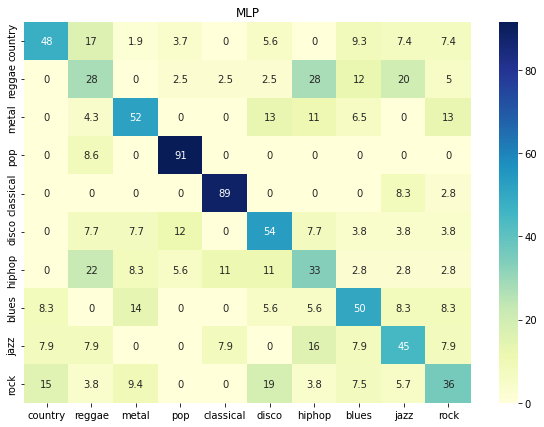

CONFUSION MATRIX FOR SVM_OVO:



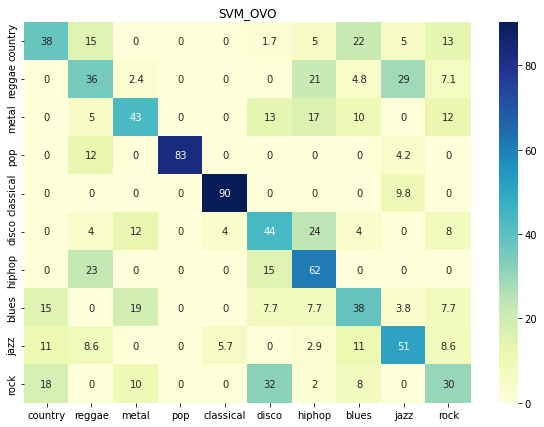

CONFUSION MATRIX FOR SVM_OVR:



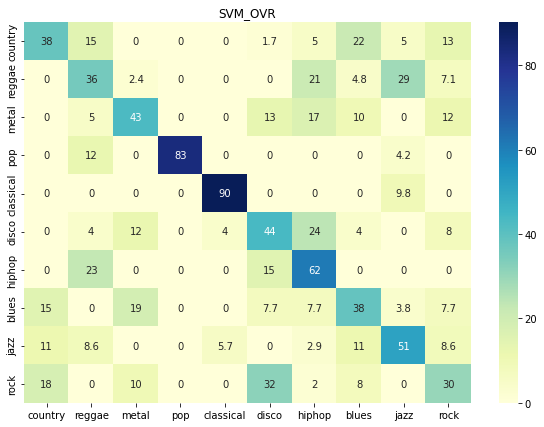

CONFUSION MATRIX FOR DECISION_TREE:



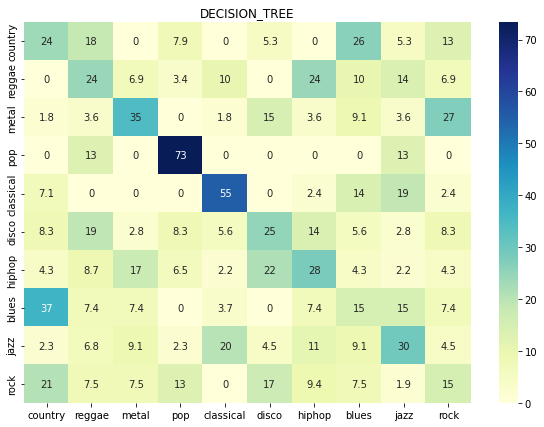

CONFUSION MATRIX FOR RANDOM_FOREST:



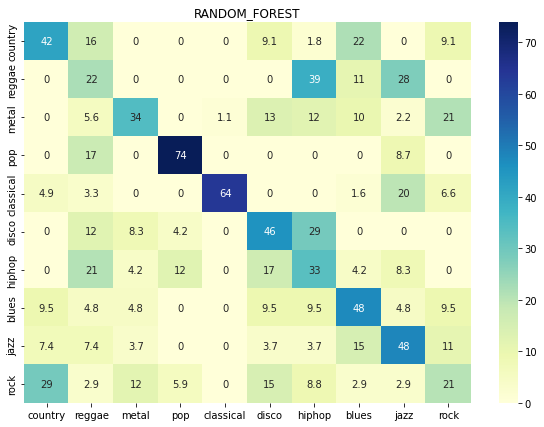

In [30]:
trainer.plot_confusion_matrix()

# 5. KMeans Clustering
We have used KMeans as part of our project to see if we can define clusters properly with in the samples and we check to see if we can assign each cluster to a set of genres. More details are available on the report.


Adjusted Rand Score: 0.162


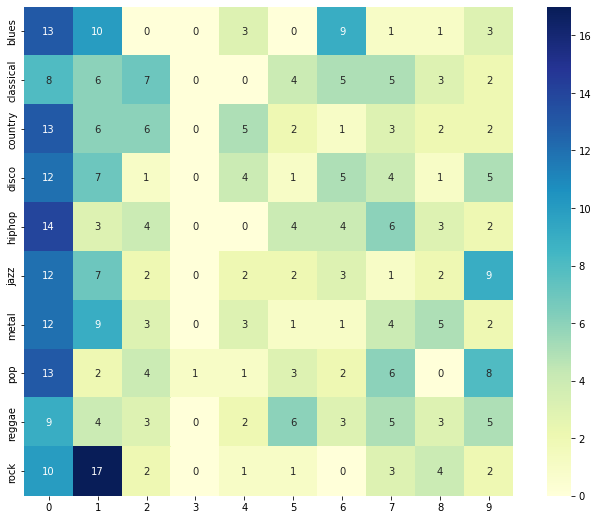

In [31]:
trained_genres = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
model = KmeansTrainer(trained_genres)
model.train(X_features, y)
y_pred_features = model.eval(X_test_features, y_test)
model.accuracy_score(X_test_features, y_test)
model.plot_adjusted_matrix(X_test_features, y_test)